In [1]:
!pip install gymnasium
!pip install torch
!pip install matplotlib  # For plotting the learning curves

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import argparse
import matplotlib.pyplot as plt

In [2]:
!pip install mujoco
!apt-get update
# !apt-get install -y --no-install-recommends nvidia-driver-460
# !apt-get install nvidia-utils-460
# Restart runtime after installing
# exit()

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


In [3]:
from torch.utils.data import TensorDataset, DataLoader # Import TensorDataset and DataLoader
import torch.nn.utils as utils # Import utils for gradient clipping

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc_mean = nn.Linear(64, action_dim)
        self.fc_std = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mean = self.fc_mean(x)
        # Use softplus to ensure std is always positive
        std = torch.nn.functional.softplus(self.fc_std(x))
        return mean, std

# Define the value network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Adjusting the part of the code that samples an action
def sample_action(policy_net, state):
    state = torch.FloatTensor(state).unsqueeze(0)
    mean, std = policy_net(state)
    dist = torch.distributions.Normal(mean, std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum()  # Summing up the log probabilities for all action dimensions
    return action, log_prob

# REINFORCE implementation

In [4]:
def reinforce(env, policy_net, optimizer, episodes=1000):
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        log_probs = []
        rewards = []

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            mean, std = policy_net(state_tensor)

            # Clip the mean and standard deviation to prevent NaN values
            mean = torch.clamp(mean, -1e6, 1e6)  # Clip mean to a large range
            std = torch.clamp(std, 1e-6, 1e6)     # Ensure std is positive and within a range
            # print(f"Mean: {mean}, Std: {std}")
            dist = torch.distributions.Normal(mean, std, validate_args=False)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum().unsqueeze(0)  # Ensure log_prob is 1D

            action = action.detach().cpu().numpy()
            if action.ndim > 1:
                action = action.flatten()

            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state

        total_rewards.append(sum(rewards))
        returns = compute_returns(torch.tensor(rewards))  # Ensure rewards are converted to a tensor

        loss = []
        for log_prob, Gt in zip(log_probs, returns):
            # Check if either log_prob or Gt is NaN, both should be tensors
            if not torch.isnan(log_prob).any() and not torch.isnan(Gt).any():
                loss.append(-log_prob * Gt)

        if loss:
            loss = torch.cat(loss).sum()
            optimizer.zero_grad()
            loss.backward()

            # Clip gradients
            utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0) # Clip gradients with max_norm=1

            optimizer.step()
        else:
            print("Empty or invalid loss array, skipping optimization.")

    plt.figure(figsize=(10,5))
    plt.plot(total_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('REINFORCE Learning Curve')
    plt.show()

    return total_rewards


def compute_returns(rewards, gamma=0.99):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns
    # pass  # Implementation here

# Policy Gradient with Baseline implementation

In [5]:
def pgb(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000):
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        log_probs = []
        rewards = []
        values = []

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            # Get mean and std from the policy network
            mean, std = policy_net(state_tensor)

            # **Clamp mean and std to prevent NaN values:**
            mean = torch.clamp(mean, -1, 1)  # Clamp mean to a reasonable range
            std = torch.clamp(std, 1e-6, 1) # Clamp std to a reasonable range and ensure it's positive

            # Create a Normal distribution
            dist = torch.distributions.Normal(mean, std)
            # Sample an action
            action = dist.sample()

            # Calculate the log probability of the action
            log_prob = dist.log_prob(action).sum()  # Sum for multi-dimensional actions
            # Ensure log_prob is a 1D tensor by unsqueezing
            log_prob = log_prob.unsqueeze(0)

            # Convert action to numpy and flatten if necessary
            action = action.detach().cpu().numpy()
            if action.ndim > 1:
                action = action.flatten()

            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            rewards.append(reward)
            values.append(value_net(state_tensor))

            state = next_state

        # Calculation of loss and optimization as before
        total_rewards.append(sum(rewards))
        returns = compute_returns(rewards)
        advantages = [ret - val.item() for ret, val in zip(returns, values)]

        policy_loss = []
        value_loss = []
        for log_prob, advantage, val, ret in zip(log_probs, advantages, values, returns):
            policy_loss.append(-log_prob * advantage)
            # Ensure val is a tensor and requires grad before performing operations
            value_loss.append((ret - val)**2) # Changed Line!

        # Stack the policy losses before summing
        policy_loss = torch.stack(policy_loss).sum() # Change here to torch.stack

        # Calculate value loss using the values stored, ensuring they require gradients
        value_loss = torch.stack(value_loss).mean() # Changed Line!

        optimizer_policy.zero_grad()
        optimizer_value.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        optimizer_policy.step()
        optimizer_value.step()

    # Plot the results
    plt.figure(figsize=(10,5))
    plt.plot(total_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('PGB Learning Curve')
    plt.show()

    return total_rewards

# PPO

In [10]:
def ppo(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000, ppo_epochs=4, mini_batch_size=64, gamma=0.99, clip_param=0.2):
    total_rewards = []

    for episode in range(episodes):
        memory = collect_trajectories(env, policy_net, steps=2048)
        batch_states, batch_actions, batch_log_probs, batch_returns, batch_advantages = process_memory(memory, value_net, gamma)

        total_rewards.append(sum(memory['rewards']))

        dataset = TensorDataset(batch_states, batch_actions, batch_log_probs, batch_returns, batch_advantages)
        loader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)

        for _ in range(ppo_epochs):
            for states, actions, old_log_probs, returns, advantages in loader:
                # Detach values used in loss calculation to prevent the RuntimeError - MOVED INSIDE THE INNER LOOP
                old_log_probs = old_log_probs.detach()
                returns = returns.detach()
                advantages = advantages.detach()

                # Get current policies and log probs
                mean, std = policy_net(states) # Get mean and std from the policy network

                # **Clamp the mean and standard deviation to prevent NaN values**
                mean = torch.clamp(mean, -1, 1)  # Clamp mean to a reasonable range
                std = torch.clamp(std, 1e-6, 1)   # Clamp std to a reasonable range and ensure it's positive

                dist = torch.distributions.Normal(mean, std) # Create a Normal distribution
                new_log_probs = dist.log_prob(actions).sum(dim=-1) # Calculate log probabilities and sum across action dimensions

                # Ratio for clipping
                ratio = (new_log_probs - old_log_probs).exp()

                # Clipped function
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantages

                # Policy loss
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value loss
                current_values = value_net(states)
                value_loss = (returns - current_values).pow(2).mean()

                # Combine policy and value loss
                loss = policy_loss + value_loss

                # Update policy and value function
                optimizer_policy.zero_grad()
                optimizer_value.zero_grad()
                loss.backward() # Backpropagate the combined loss
                optimizer_policy.step()
                optimizer_value.step()


    # Plot the results
    plt.figure(figsize=(10,5))
    plt.plot(total_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('PPO Learning Curve')
    plt.show()

    return total_rewards

def collect_trajectories(env, policy, steps=2048):
    state = env.reset()
    log_probs = []
    states = []
    actions = []
    rewards = []
    done = False
    step = 0

    while step < steps and not done:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        # Get mean and std for continuous action space
        mean, std = policy(state_tensor)

         # Clamp mean and std to prevent NaN values:
        # Use tanh to keep mean within [-1, 1] and softplus for positive std
        mean = torch.tanh(mean)  # Keep mean within [-1, 1]
        std = torch.nn.functional.softplus(std) + 1e-6  # Ensure std is positive

        # Create a Normal distribution
        dist = torch.distributions.Normal(mean, std)
        # Sample an action
        action = dist.sample()
        # Get log probability
        log_prob = dist.log_prob(action).sum().unsqueeze(0)

        # Take action in the environment
        next_state, reward, done, _ = env.step(action.detach().cpu().numpy().flatten())  # Flatten action if necessary

        # Store experience
        states.append(state_tensor)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)

        state = next_state
        step += 1

        if done:
            state = env.reset()  # Reset environment if done

    return {
        "states": states,
        "actions": actions,
        "rewards": rewards,
        "log_probs": log_probs
    }


def process_memory(memory, value_net, gamma):
    rewards = memory['rewards']
    log_probs = memory['log_probs']
    states = torch.cat(memory['states'])
    actions = torch.cat(memory['actions'])
    log_probs = torch.cat(log_probs)

    # Compute returns
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    values = value_net(states)

    # Normalize returns
    returns = (returns - returns.mean()) / (returns.std() + 1e-5)

    # Compute advantages
    advantages = returns - values.detach().squeeze()

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

    return states, actions, log_probs, returns, advantages


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


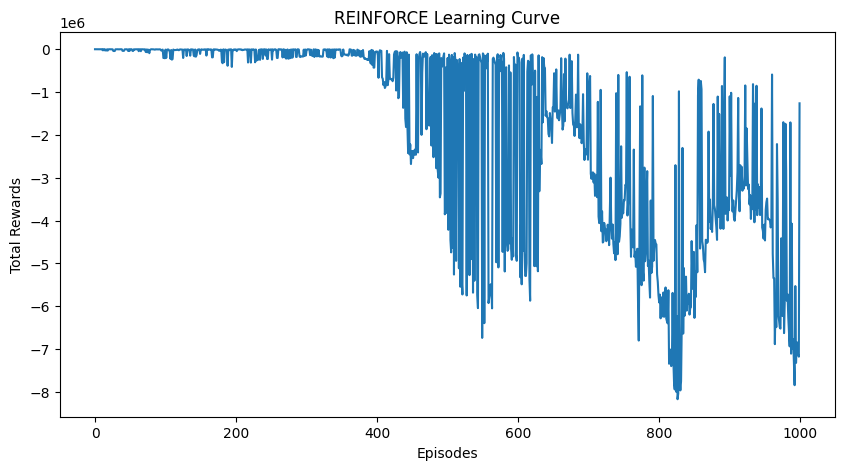

In [7]:
def main(args):
    env = gym.make('Ant-v4')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]  # Use shape for Box spaces

    policy_net = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)

    optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.01)
    optimizer_value = optim.Adam(value_net.parameters(), lr=0.01)

    if args.algo == 'pg':
        reinforce(env, policy_net, optimizer_policy, episodes=1000)
    elif args.algo == 'pgb':
        pgb(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000)
    elif args.algo == 'ppo':
        ppo(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000, ppo_epochs=4, mini_batch_size=64, gamma=0.99, clip_param=0.2)
    else:
        raise ValueError("Unsupported algorithm. Choose from ['pg', 'pgb', 'ppo']")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--algo', type=str, default='pg', help='Algorithm to use: pg, pgb, ppo')
    args, unknown = parser.parse_known_args()
    main(args)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


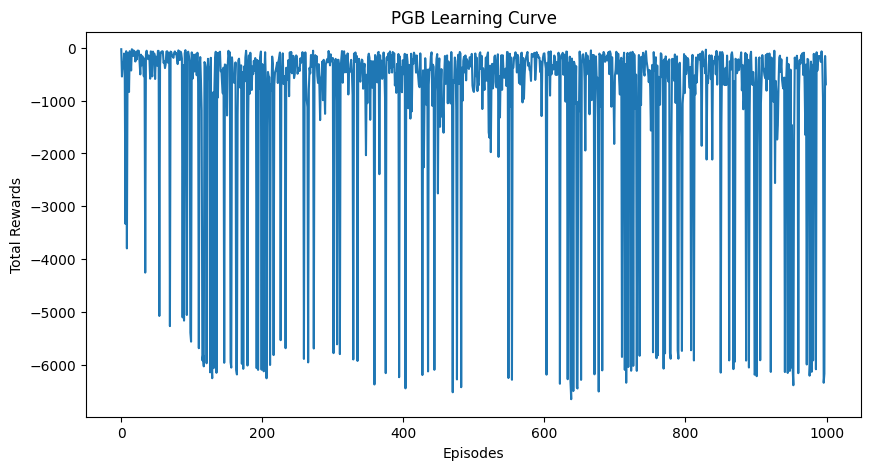

In [8]:
def main(args):
    env = gym.make('Ant-v4')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]  # Use shape for Box spaces

    policy_net = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)

    optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.01)
    optimizer_value = optim.Adam(value_net.parameters(), lr=0.01)

    if args.algo == 'pg':
        reinforce(env, policy_net, optimizer_policy, episodes=1000)
    elif args.algo == 'pgb':
        pgb(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000)
    elif args.algo == 'ppo':
        ppo(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000, ppo_epochs=4, mini_batch_size=64, gamma=0.99, clip_param=0.2)
    else:
        raise ValueError("Unsupported algorithm. Choose from ['pg', 'pgb', 'ppo']")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--algo', type=str, default='pgb', help='Algorithm to use: pg, pgb, ppo')
    args, unknown = parser.parse_known_args()
    main(args)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


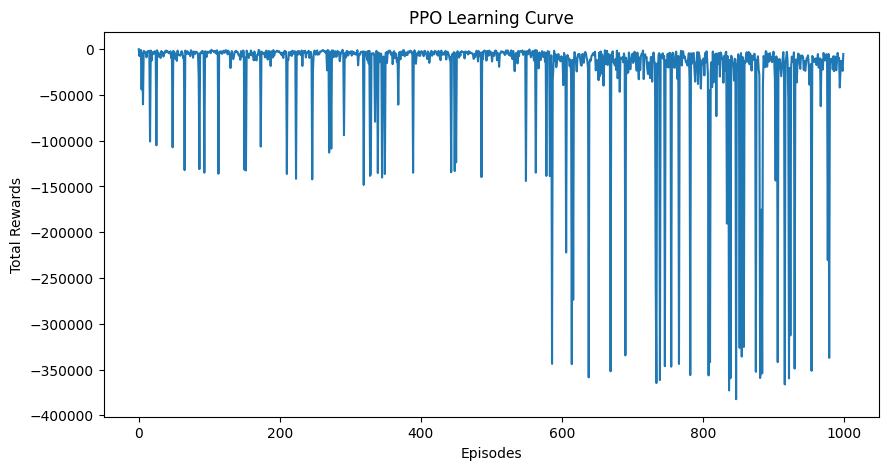

In [11]:
def main(args):
    env = gym.make('Ant-v4')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]  # Use shape for Box spaces

    policy_net = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)

    optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.01)
    optimizer_value = optim.Adam(value_net.parameters(), lr=0.01)

    if args.algo == 'pg':
        reinforce(env, policy_net, optimizer_policy, episodes=1000)
    elif args.algo == 'pgb':
        pgb(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000)
    elif args.algo == 'ppo':
        ppo(env, policy_net, value_net, optimizer_policy, optimizer_value, episodes=1000, ppo_epochs=4, mini_batch_size=64, gamma=0.99, clip_param=0.2)
    else:
        raise ValueError("Unsupported algorithm. Choose from ['pg', 'pgb', 'ppo']")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--algo', type=str, default='ppo', help='Algorithm to use: pg, pgb, ppo')
    args, unknown = parser.parse_known_args()
    main(args)
